# Imports

In [47]:
# Python standard library
import glob
import os

# Third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import screed
import seaborn as sns

# Local python files
from path_constants import FIGURE_FOLDER, DATA_FOLDER
from nb_utils import describe
from plot_constants import (
    PROTEIN_COLOR,
    DAYHOFF_COLOR,
    PEPTIDE_MOLTYPE_PALETTE,
    PEPTIDE_MOLTYPE_ORDER,
    PEPTIDE_ALPHABET_KSIZES,
    PEPTIDE_ALPHABET_PALETTES,
)
from mya_utils import clean_common_names_of_species, BUSCO_MAMMALIA_SPECIES


## Read ROC Curve csv

In [54]:
parquet = os.path.join(
    DATA_FOLDER,
    "orpheum-benchmarking",
    "busco_mammalia_coding_scores_roc_curves.parquet",
)


combined_roc_curve = pd.read_parquet(parquet)
# Things aren't better at k>21, even with dayhoff
combined_roc_curve = combined_roc_curve.query("ksize <= 21")
combined_roc_curve["proteome"] = (
    combined_roc_curve["species"]
    .map(clean_common_names_of_species)
    .str.replace("_", " ")
)
combined_roc_curve = combined_roc_curve.join(
    BUSCO_MAMMALIA_SPECIES.reset_index().set_index("common_name"), on="proteome"
)
combined_roc_curve.head()

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,proteome,scientific_lower,scientific_name,mya
0,baiji,dayhoff,5,0,0.000000,0.000000,2.000000,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
1,baiji,dayhoff,5,1,0.000820,0.000705,1.000000,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
2,baiji,dayhoff,5,2,0.000820,0.000717,0.977778,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
3,baiji,dayhoff,5,3,0.000825,0.000726,0.977273,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
4,baiji,dayhoff,5,4,0.000842,0.000742,0.976744,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0


In [55]:
combined_roc_curve.dtypes

species              object
alphabet             object
ksize                 int64
threshold_i           int64
fpr                 float64
tpr                 float64
thresholds          float64
score_name           object
proteome             object
scientific_lower     object
scientific_name      object
mya                 float64
dtype: object

## Get number of protein sequences per species

In [56]:
proteome_folder = os.path.join(
    DATA_FOLDER, "orpheum-benchmarking", "mammalia_busco_subsets"
)

busco_mammalia_species = BUSCO_MAMMALIA_SPECIES.copy()

col = "proteome_size"
busco_mammalia_species[col] = 0
for fasta in glob.glob(os.path.join(proteome_folder, "*.fasta")):
    species_lower = os.path.basename(fasta).split("__")[-1].split(".")[0]
    proteome_size = sum(1 for _ in screed.open(fasta))

    busco_mammalia_species.loc[species_lower, col] = proteome_size
busco_mammalia_species = busco_mammalia_species.sort_values("mya")
describe(busco_mammalia_species)

(18, 4)
--- First 5 entries ---


,common_name,scientific_name,mya,proteome_size
scientific_lower,,,,
homo_sapiens,human,Homo sapiens,0.0,15066
macaca_mulatta,macaque,Macaca mulatta,29.4,5008
aotus_nancymaae,night monkey,Aotus nancymaae,43.2,7261
tupaia_chinensis,tupaia,Tupaia chinensis,82.0,1338
mus_musculus,house mouse,Mus musculus,90.0,14519


In [57]:
sorted(combined_roc_curve['proteome'].unique())

['baiji',
 'bat',
 'camel',
 'chinchilla',
 'common shrew',
 'deer mouse',
 'goat',
 'hedgehog',
 'house mouse',
 'human',
 'koala',
 'macaque',
 'night monkey',
 'platypus',
 'rabbit',
 'rhino',
 'spalax',
 'tupaia']

## Plot ROC curves

### Plot combined roc curves

In [58]:
busco_mammalia_species.sort_values('proteome_size')

,common_name,scientific_name,mya,proteome_size
scientific_lower,,,,
rhinolophus_sinicus,bat,Rhinolophus sinicus,96.0,1
peromyscus_maniculatus_bairdii,deer mouse,Peromyscus Maniculatus bairdii,90.0,1
ceratotherium_simum_simum,rhino,Ceratotherium simum simum,96.0,1
nannospalax_galili,spalax,Nannospalax galili,90.0,3
chinchilla_lanigera,chinchilla,Chinchilla lanigera,90.0,3
camelus_bactrianus,camel,Camelus bactrianus,96.0,4
phascolarctos_cinereus,koala,Phascolarctos cinereus,159.0,6
lipotes_vexillifer,baiji,Lipotes vexillifer,96.0,8
sorex_araneus,common shrew,Sorex araneus,96.0,36


In [59]:
busco_mammalia_species_min_proteome_size = busco_mammalia_species.query(
    "proteome_size >= 2000"
)
busco_mammalia_species_min_proteome_size

,common_name,scientific_name,mya,proteome_size
scientific_lower,,,,
homo_sapiens,human,Homo sapiens,0.0,15066
macaca_mulatta,macaque,Macaca mulatta,29.4,5008
aotus_nancymaae,night monkey,Aotus nancymaae,43.2,7261
mus_musculus,house mouse,Mus musculus,90.0,14519
oryctolagus_cuniculus,rabbit,Oryctolagus cuniculus,90.0,4424
erinaceus_europaeus,hedgehog,Erinaceus europaeus,96.0,13448


In [60]:
busco_mammalia_species_min_proteome_size.shape

(6, 4)

In [61]:
combined_roc_curve

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,proteome,scientific_lower,scientific_name,mya
0,baiji,dayhoff,5,0,0.000000,0.000000,2.000000,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
1,baiji,dayhoff,5,1,0.000820,0.000705,1.000000,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
2,baiji,dayhoff,5,2,0.000820,0.000717,0.977778,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
3,baiji,dayhoff,5,3,0.000825,0.000726,0.977273,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
4,baiji,dayhoff,5,4,0.000842,0.000742,0.976744,roc_auc,baiji,lipotes_vexillifer,Lipotes vexillifer,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...
116360,tupaia,protein,21,55,0.000006,0.083814,0.068966,roc_auc,tupaia,tupaia_chinensis,Tupaia chinensis,82.0
116361,tupaia,protein,21,56,0.000006,0.085138,0.066667,roc_auc,tupaia,tupaia_chinensis,Tupaia chinensis,82.0
116362,tupaia,protein,21,57,0.000006,0.088149,0.034483,roc_auc,tupaia,tupaia_chinensis,Tupaia chinensis,82.0
116363,tupaia,protein,21,58,0.000006,0.089707,0.033333,roc_auc,tupaia,tupaia_chinensis,Tupaia chinensis,82.0


In [62]:
combined_roc_curve_min_proteome_sizes = combined_roc_curve.query(
    "proteome in @busco_mammalia_species_min_proteome_size.common_name.values"
)
# combined_roc_curve_min_proteome_sizes['scientific_lower'] = combined_roc_curve_min_proteome_sizes
combined_roc_curve_min_proteome_sizes.shape

combined_roc_curve_min_proteome_sizes.proteome.unique()

array(['hedgehog', 'human', 'macaque', 'house mouse', 'night monkey',
       'rabbit'], dtype=object)

In [63]:
combined_roc_curve_min_proteome_sizes

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,proteome,scientific_lower,scientific_name,mya
21295,hedgehog,dayhoff,5,0,0.000000,0.000000,2.000000,roc_auc,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0
21296,hedgehog,dayhoff,5,1,0.874543,0.867155,1.000000,roc_auc,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0
21297,hedgehog,dayhoff,5,2,0.877700,0.871383,0.978261,roc_auc,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0
21298,hedgehog,dayhoff,5,3,0.886529,0.881578,0.977778,roc_auc,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0
21299,hedgehog,dayhoff,5,4,0.891312,0.885354,0.977273,roc_auc,hedgehog,erinaceus_europaeus,Erinaceus europaeus,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95175,rabbit,protein,21,64,0.000127,0.257454,0.037037,roc_auc,rabbit,oryctolagus_cuniculus,Oryctolagus cuniculus,90.0
95176,rabbit,protein,21,65,0.000132,0.257454,0.035714,roc_auc,rabbit,oryctolagus_cuniculus,Oryctolagus cuniculus,90.0
95177,rabbit,protein,21,66,0.000200,0.266658,0.034483,roc_auc,rabbit,oryctolagus_cuniculus,Oryctolagus cuniculus,90.0
95178,rabbit,protein,21,67,0.000200,0.271330,0.033333,roc_auc,rabbit,oryctolagus_cuniculus,Oryctolagus cuniculus,90.0


In [64]:
combined_roc_curve_min_proteome_sizes.scientific_name.unique()

array(['Erinaceus europaeus', 'Homo sapiens', 'Macaca mulatta',
       'Mus musculus', 'Aotus nancymaae', 'Oryctolagus cuniculus'],
      dtype=object)

In [65]:
species_order = busco_mammalia_species_min_proteome_size['scientific_name']
species_order

scientific_lower
homo_sapiens                      Homo sapiens
macaca_mulatta                  Macaca mulatta
aotus_nancymaae                Aotus nancymaae
mus_musculus                      Mus musculus
oryctolagus_cuniculus    Oryctolagus cuniculus
erinaceus_europaeus        Erinaceus europaeus
Name: scientific_name, dtype: object

# SFig B,C

dayhoff
protein


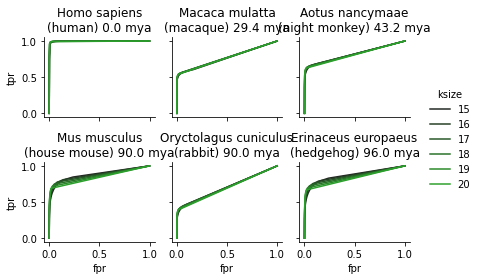

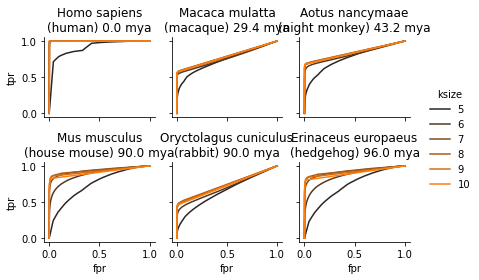

In [66]:
for alphabet, df in combined_roc_curve_min_proteome_sizes.groupby("alphabet"):
    print(alphabet)
    hue_order = PEPTIDE_ALPHABET_KSIZES[alphabet]
    palette = PEPTIDE_ALPHABET_PALETTES[alphabet]
    g = sns.FacetGrid(
        data=df,  # col='alphabet',
        hue="ksize",
        palette=palette,
        col="scientific_name",
        col_order=species_order,
        col_wrap=3,
        height=2,
        hue_order=hue_order,
    )
    g.map(plt.plot, "fpr", "tpr")
    g.add_legend()
    g.set(xticks=[0, 0.5, 1], yticks=[0, 0.5, 1])
    g.set_titles("{col_name}")
    
    for ax in g.axes.flat:
        scientific_name = ax.get_title()
        this_species_metadata =  busco_mammalia_species_min_proteome_size.query('scientific_name == @scientific_name')
        common_name = this_species_metadata.common_name.iloc[0]
        mya = this_species_metadata.mya.iloc[0]
        new_title = f'{scientific_name}\n({common_name}) {mya} mya'
        ax.set_title(new_title)
        
    # Save the figure
    pdf = os.path.join(
        FIGURE_FOLDER, f"orpheum_translate__roc_curves_all_proteomes__{alphabet}.pdf"
    )
    g.tight_layout()
    g.savefig(pdf)